In [5]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [6]:
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [7]:
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [8]:
desminado  = pd.read_csv('SituacionDesminadoHumanitario.csv')
educacion  = pd.read_csv('EducacionRiesgoMinas.csv')
casos      = pd.read_csv('EventosMinas.csv')
victimas   = pd.read_csv('VictimasMinas.csv')
municipios = pd.read_csv('MunicipiosDANE.csv')

In [9]:
educacion["FECHA_FINALIZACION"] = pd.to_datetime(educacion["FECHA_FINALIZACION"])
educacion["FECHA_INICIO"] = pd.to_datetime(educacion["FECHA_INICIO"], format="%m/%d/%Y %I:%M:%S %p", infer_datetime_format=False)   # 11/13/2019 12:00:00 AM    "%m/%d/%Y %I:%M:%S %p"
educacion["DURACION"] = educacion["FECHA_FINALIZACION"] - educacion["FECHA_INICIO"]
educacion["DURACION"] = educacion["DURACION"].apply(lambda x: x.days+1)
educacion = educacion[educacion["DURACION"] == 1]

In [10]:
victimas = victimas.rename(columns={"ano":"AÑO","mes":"MES","codigodanemunicipio":"CODIGO_DANE_MUNICIPIO"})

In [11]:
# date: month,year
def filterData(df, mun_dane_code=None, date=(None,None)):
  victimas = df
  month, year = date
  if month != None and year != None:
    victimas = victimas[(victimas["AÑO"]==year) & (victimas["MES"]==month)]
  if mun_dane_code != None:
    victimas = victimas[victimas["CODIGO_DANE_MUNICIPIO"] == mun_dane_code]
  return victimas

In [12]:
def getDate(month,year):
    if month < 10:
        fecha = '01/0' + str(month) + '/' + str(year)
    else:
        fecha = '01/' + str(month) + '/' + str(year)
    return fecha

In [13]:
def getDateAux(date):
    month,year = date
    return getDate(month,year)

In [202]:
def getTimeSeries(df,mun_dane_code):
    for year in range(1990,2020):
        for month in range(1,12):
            fecha = getDate(month,year)
            casos_filtered = filterData(casos,mun_dane_code,date=(month,year))
            nCasos = len(casos_filtered)
            row = { 'fecha':fecha,
                    'casos':nCasos,
                    #'municipio':mun_dane_code
                  }
            #if nCasos > 0:
            df = df.append(row, ignore_index=True)
    return df

In [229]:
#municipio = 52835  # Tumaco
municipio = 50711  # Vista Hermosa - Meta
#municipio = 50251   # El castillo - Meta
df = pd.DataFrame({'casos': pd.Series([], dtype='int'),
                   'fecha': pd.Series([], dtype='string')})
timeSeries = pd.DataFrame(columns=['fecha','casos'])
timeSeries = getTimeSeries(timeSeries,municipio)
timeSeries['fecha'] = pd.to_datetime(timeSeries['fecha'], format='%d/%m/%Y')
timeSeries['casos'] = pd.to_numeric(timeSeries['casos'])
timeSeries = timeSeries.set_index('fecha')
#timeSeries.sort_index(inplace=True)
#timeSeries = timeSeries['casos']

In [230]:
municipios[municipios["CÓDIGO DANE DEL MUNICIPIO"] == 50251]
#municipios.keys()
#timeSeries

,REGION,CÓDIGO DANE DEL DEPARTAMENTO,DEPARTAMENTO,CÓDIGO DANE DEL MUNICIPIO,MUNICIPIO
660,Región Llano,50,Meta,50251,El Castillo


<AxesSubplot:xlabel='fecha'>

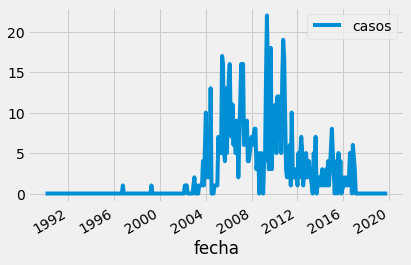

In [231]:
timeSeries.plot()

In [232]:
timeSeries

,casos
fecha,
1990-01-01,0
1990-02-01,0
1990-03-01,0
1990-04-01,0
1990-05-01,0
...,...
2019-07-01,0
2019-08-01,0
2019-09-01,0


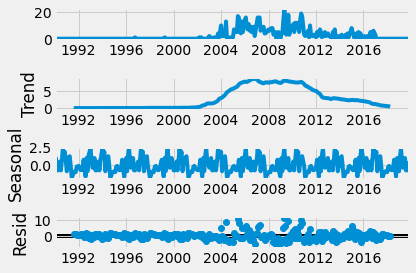

In [233]:
decomposition = sm.tsa.seasonal_decompose(x=timeSeries, model='additive', period=12*3)
_ = decomposition.plot()

## ARIMA
* Autoregressive integrated moving average
* Modelo autorregresivo integrado de media móvil

In [234]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [235]:
scores = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(timeSeries,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            score = 'ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
            scores.append(score)
        except:
            continue

C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWa

C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWa

C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWa

C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWa

C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWa

In [236]:
for score in scores:
    print(score)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1959.76355627958
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1780.507697975269
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1750.3793191345967
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1651.204726584017
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1703.0069195108524
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1685.4645623705892
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1667.8690355604494
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1653.2044376672152
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1792.5262930331653
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1674.4775866433743
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1705.0406837762794
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1591.7095253537736
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1642.6449019413535
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1621.5698859869433
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1620.7595121673053
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1593.7088160390408
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1695.9755852033175
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1637.4245239564

In [237]:
# Take lowest AIC VALUE
# ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:2909.8256452739265

In [238]:
mod = sm.tsa.statespace.SARIMAX(timeSeries,
                               order=(1,1,1),
                               seasonal_order=(0,1,1,12),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2392      0.048      5.012      0.000       0.146       0.333
ma.L1         -0.8487      0.029    -28.938      0.000      -0.906      -0.791
ma.S.L12      -1.0000    320.073     -0.003      0.998    -628.332     626.332
sigma2         7.6720   2455.794      0.003      0.998   -4805.596    4820.940


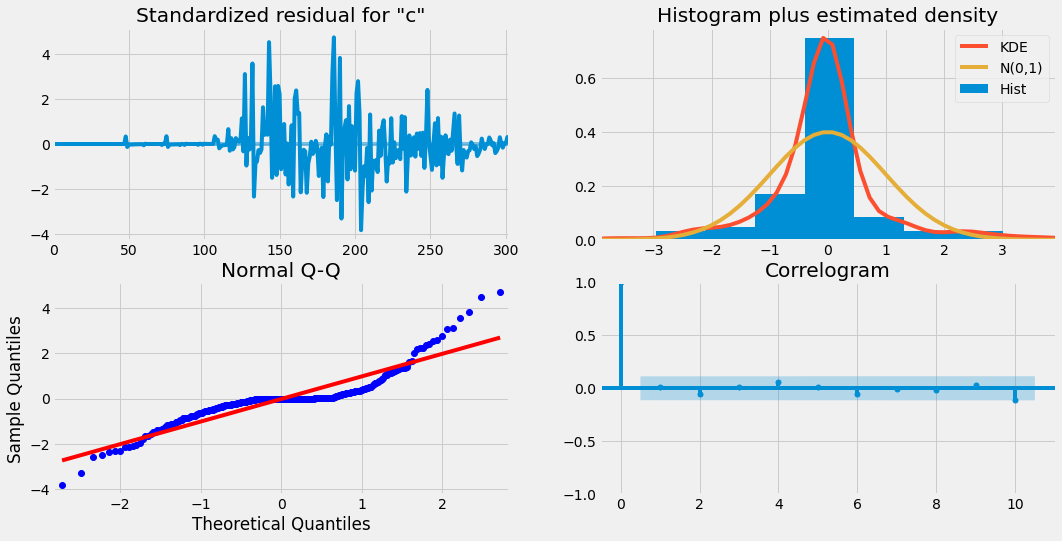

In [239]:
_ = results.plot_diagnostics(figsize=(16,8))

In [253]:
results.

(array([ 1.        , -0.84865405]), array([ 1.       , -0.2391511]))

## Validación

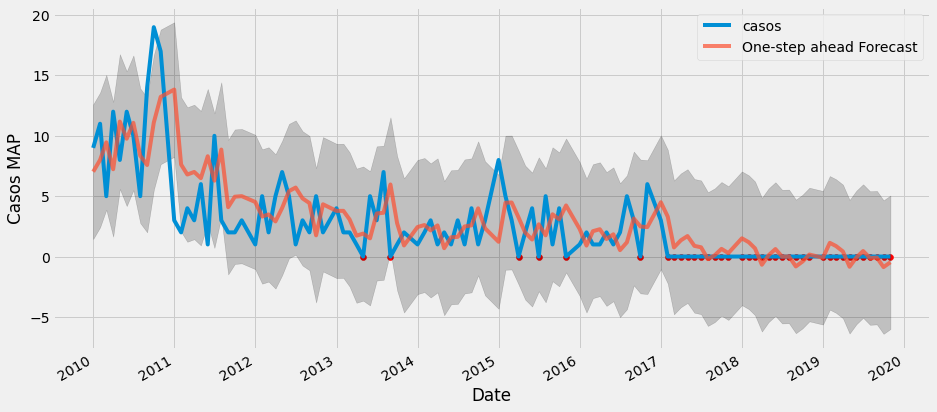

In [240]:
pred = results.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
dataSubset = timeSeries['2010':]
pred_ci = pred.conf_int()
ax = dataSubset.plot(label='observed')
points = dataSubset[dataSubset == 0]
plt.scatter(points.index, points.values, color='red')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Casos MAP')
plt.legend()

In [241]:
y_forecasted = pred.predicted_mean
y_truth = timeSeries['2010-01-01':]['casos']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 7.7
The Root Mean Squared Error of our forecasts is 2.78


In [242]:
''' In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit. Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far. '''

' In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit. Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far. '

In [243]:
# FUENTE PARA CITAR
'https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b'

'https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b'

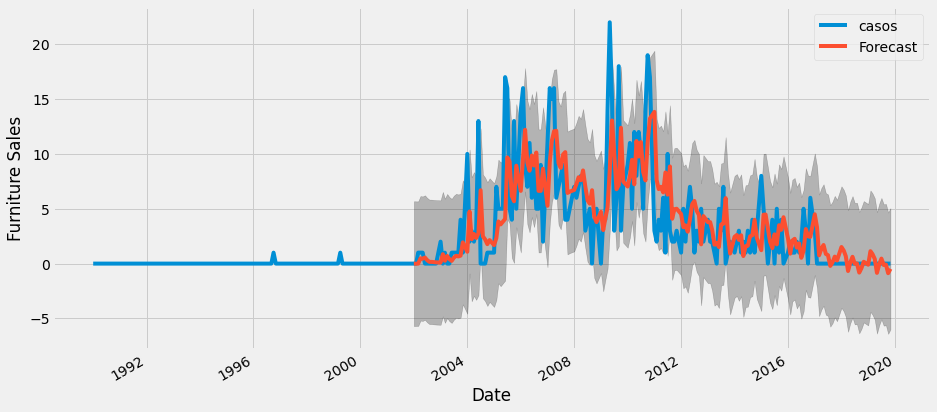

In [244]:
pred = results.get_prediction(start=pd.to_datetime('2002-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = timeSeries.plot(label='observed', figsize=(14, 7))
pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

In [245]:
import math

# currentDate: month,year
def getNextDate(currentDate, nMonthsAfter):
  month, year = currentDate
  if nMonthsAfter > 0:
    month = month + nMonthsAfter
    newYear = year + math.floor(month / 12)
    newMonth = month % 12
    if newMonth == 0:
      return 12,newYear-1
  return newMonth,newYear

C:\Users\Andres\anaconda3\envs\jupyter\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


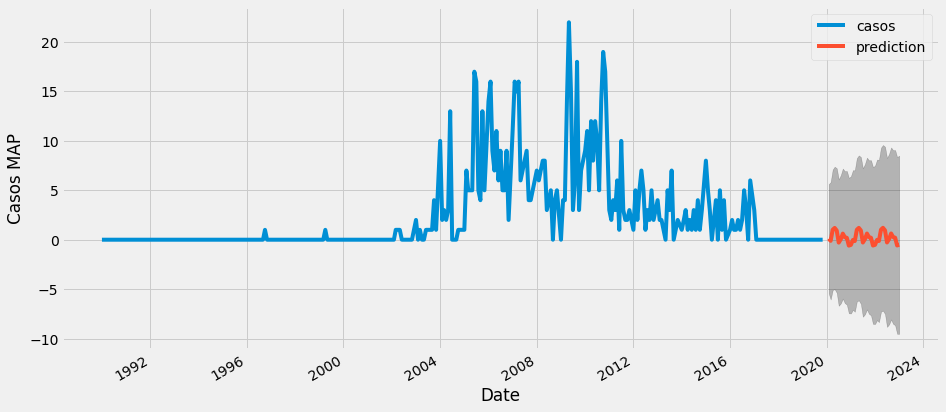

In [246]:
pred_uc = results.get_forecast(steps=12*3, dynamic=False)
pred_ci = pred_uc.conf_int()
ax = timeSeries.plot(label='observed', figsize=(14, 7))
startDate = (1,2020)
pred_ci = pred_uc.conf_int()
pred_ci['fecha'] = pred_ci.index.map(lambda i: getDateAux(getNextDate(startDate,i-329)))
pred_ci['fecha'] = pd.to_datetime(pred_ci['fecha'], format='%d/%m/%Y')
pred_ci = pred_ci.set_index('fecha')

forecast = pd.DataFrame( {'prediction': pred_uc.predicted_mean} )
forecast['fecha'] = forecast.index.map(lambda i: getDateAux(getNextDate(startDate,i-329)))
forecast['fecha'] = pd.to_datetime(forecast['fecha'], format='%d/%m/%Y')
forecast = forecast.set_index('fecha')
forecast.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Casos MAP')
plt.legend()